## Processing Ocean Color Imagery - Process Micasense Images

This notebook basically just runs the Micasense imageprocessing code and then inspects gain/exposure/ed

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
from georeg import *

### Process the Imagery

In [3]:
! ls data/20210317_duml_360_altitude_testing/altitude_test

000  diag.dat	  IMG_0100_1.txt  panel		thumbnails
001  gpslog.dat   IMG_0105_1.txt  paramlog.dat	varying_altitude
002  hostlog.dat  new.txt	  stacks	xy_coords


This is the panel we could use.

In [4]:
glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0002*.tif'))

['data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_5.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_2.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_6.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_4.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_3.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_1.tif']

I'm using the panel from the flight 1 hour before this one, the one we took for this flight was too close and unusable. This day was totally overcast and not changing much so this should be appropriate and I've run both but we're just using DLS in this example.

In [5]:
panelNames = None
#panelNames = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0002_*.tif'))
alt_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude')

warp_img_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude', 'align_img')

altitude_out = process_micasense_subset(alt_dir, panelNames, warp_img_dir, overwrite=False)

Not using panel irradiance.
used warp dir data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 4
Finished aligning band 1
Saving time: 0:17:27.433793
Alignment+Saving rate: 0.32 images per second
Finished saving images.
exiftool -csv="data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/log.csv" -overwrite_original data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks
Finished saving image metadata.


Write the exif data into the imagery.

In [6]:
! exiftool -csv="data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/log.csv" -overwrite_original data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks

    1 directories scanned
  338 image files updated


### Images are now fully processed, let's inspect how exposure, gain and Ed change throughout this flight period.

In [9]:
imgset = imageset.ImageSet.from_directory(alt_dir)

Grab Ed, exposure, and gain from every image and every band

In [64]:
dls_ed = []
exposures = []
gains = []
for cap in imgset.captures:
    if len(cap.dls_irradiance()) == 6:
        dls_ed.append(np.array(cap.dls_irradiance()))
        exp = []
        gain_cap = []
        for img in cap.images: 
            exp.append(img.exposure_time)
            gain_cap.append(img.gain)
        exposures.append(exp)
        gains.append(gain_cap)
        
exposures = np.array(exposures)
gains = np.array(gains)
dls_ed = np.array(dls_ed)

Visualize this over the period of the altitude experiment.

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/

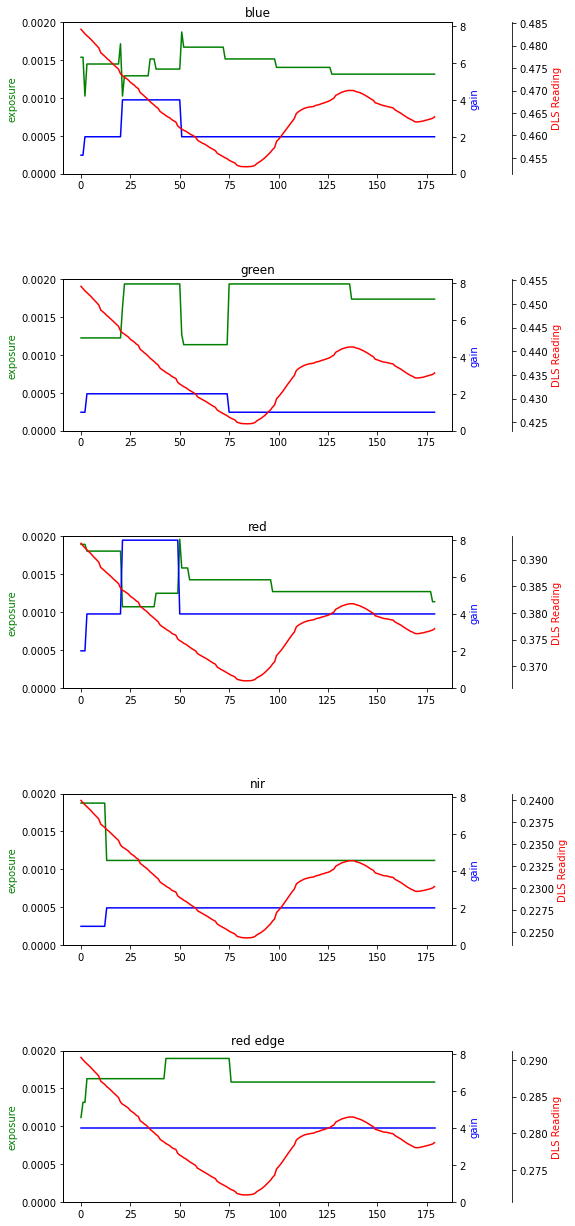

In [94]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']

fig, ax = plt.subplots(5,1, figsize=(12,18))

for i in range(5):
    ax[i].plot(exposures[100:280,i], color='green')
    ax[i].set_ylim(0,.002)
    ax2 = ax[i].twinx()
    ax2.plot(gains[100:280,i], color='blue')
    ax2.set_ylim(0,8.2)
    ax3 = ax[i].twinx()
    ax3.plot(dls_ed[100:280,i], color='red')
#     ax3.set_ylim(.22,.5)
    ax3.spines['right'].set_position(('outward', 60))
    
    ax[i].set_ylabel('exposure')
    ax2.set_ylabel('gain')
    ax3.set_ylabel('DLS Reading')
    
    ax[i].yaxis.label.set_color('green')
    ax2.yaxis.label.set_color('blue')
    ax3.yaxis.label.set_color('red')
    
    ax[i].set_title(band_names[i])
    fig.tight_layout()
    fig.savefig('gain_exposure_dls.png',dpi=300)
    fig.show()
#     

### Comparing the DLS irradiance to the panel irradiance

We're using DLS but note that the panel Ed is a fair bit different.

In [85]:
panel_cap = capture.Capture.from_filelist(glob.glob('data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002*'))

In [98]:
panel_reflectance_by_band = [.539,.539,.538,.534,.537]

panel_radiances = np.array(panel_cap.panel_radiance())
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band

In [99]:
irr_from_panel

array([0.32822018, 0.33827115, 0.27919627, 0.16799613, 0.21271497])